<a href="https://colab.research.google.com/github/laurabustamante/foraging_tutorial/blob/main/foraging_tutorial_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foraging theory: models and applications to effort-based decision-making
<br>
Welcome to the tutorial! This tutorial was written by Laura Ana Bustamante from Washington University in St. Louis in April, 2024. Much of the code was adapted from scripts provided to me by Nathaniel Daw, Sean Devine, Kevin Lloyd and Sam Zorowitz, many thanks to them.
<br>
In this tutorial you will learn about how to run simulations to get the optimal policy in a patch foraging environment. Then you will estimate individual differences in willingness to exert cognitive and physical effort by fitting a hierarchical Bayesian MVT model. We will also cover how to utilize hierarchical models to estimate correlations between inter-parameter individual differences. We will use open source Effort Foraging Task data from Bustamante and colleagues (2023).
<br>
See the [paper](https://www.pnas.org/doi/10.1073/pnas.2221510120) and [OSF](https://osf.io/a4r2e/) repository for complete information.

# Setup
Install and load packages, load data, and other required files.

In [1]:
install.packages("R.utils", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("HDInterval", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("lme4", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’




In [5]:
library(lme4)
library(R.utils)
library(magrittr)
library(tidyr)
library(data.table)
library(dplyr)
library(ggplot2)

Loading required package: Matrix

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.26.0 (2024-01-24 05:12:50 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.3 (2023-11-18 01:00:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, warnings



Attaching package: ‘magrittr’


The following object is masked from ‘package:R.utils’:

    extract


The following object is mask

# Simulating patch foraging task to find the best policy

First we are going to find the MVT best threshold policy for the foraging environment that participants experiences. This simulated foraging agent, will complete a patch foraging task using fixed exit threshold, and we can then observe the observing the resulting reward rate achieved.

To find the best threshold, we used a policy iteration algorithm to find the maximal reward rate for a given foraging environment. The foraging environment was defined by the following parameters from our experiments; the harvest time (2 seconds), travel time (8.33 seconds), the distribution of initial rewards to a tree (N(15, 1)) distribution of the decay function (beta distribution,(alpha=14.90873, beta=2.033008). We assumed the agent knew the mean depletion rate (0.88 multiplied by the previous reward) and used this value to predict the expected reward on the current trial. If the predicted reward ```Er``` was less than or equal to the agent’s threshold ```thresh``` it exited the patch, otherwise it harvested the patch which yielded reward.

```
# Calculate expected reward based on decay rate
Er <- E_kappa * r
if (Er < thresh) {
  # If expected reward is below threshold, exit
  t_counter <- t_counter + d
  exit_harvest_counter <- c(exit_harvest_counter, harvest_counter)
  exit_harvest_counter_i <- c(exit_harvest_counter_i, harvest_counter)
  harvest_counter <- 0
} else {
  # If expected reward is above threshold, continue harvesting
  kappa <- rbeta(1, shape1 = a, shape2 = b)
  r <- kappa * r
  r_counter <- r_counter + r
  t_counter <- t_counter + h
  harvest_counter <- harvest_counter + 1
}
```

We simulated 480 ‘seconds’ of foraging time for all experiments (though the result should be robust to duration). The simulation outputs were the ‘best threshold’ (threshold that yielded the highest reward rate, results vary slightly by simulation run), the resulting `best reward rate', as well as the mean and standard deviation number of harvests to reach that exit threshold.

The agents' threshold parameter was initialized at 4 apples. For an iteration i, the threshold was set as the mean reward rate observed in iteration i-1, this allowed the threshold to gradually improve in terms of reward rate between iterations. The simulation stopped and the best threshold was determined based on the stopping threshold of a 0.001 apple per second improvement in reward rate on iteration i compared iteration i-1 (with a maximum of 200 iterations).

In [7]:
# Define the optimal_threshold function
optimal_threshold <- function(d, h, mu, sigma, a, b, time) {

  # Initialize variables
  thresh_old <- 4
  tol <- 1e-3
  max_iter <- 200
  diff <- 1e3
  iter_opt <- 0

  # Iterate until convergence or maximum iterations reached
  while (diff > tol && iter_opt < max_iter) {
    iter_opt <- iter_opt + 1
    # Call evaluate_threshold function to get results
    results <- evaluate_threshold(thresh_old, max_iter, d, h, mu, sigma, a, b, time)
    # Update threshold based on average reward rate
    thresh_new <- results$rho_mean * h
    diff <- abs(thresh_new - thresh_old)
    thresh_old <- thresh_new
    # Display iteration information
    cat("iteration", iter_opt, "...")
    cat("... threshold value =", thresh_old, "...")
    cat("... average rho =", results$rho_mean, "\n")
  }

  # Return results as a list
  list(thresh = thresh_new,
       rho = results$rho_mean,
       n_harvests_mean = results$n_harvest_mean,
       n_harvests_sd = results$n_harvest_sd,
       n_exits_mean = results$n_exit_mean,
       n_exits_sd = results$n_exit_sd)
}

# Define the evaluate_threshold function
evaluate_threshold <- function(thresh, iter_eval, d, h, mu, sigma, a, b, time) {

  # Initialize variables
  r_max <- mu + 5
  E_kappa <- a / (a + b)
  exit_harvest_counter <- c()
  rho <- numeric(iter_eval)
  num_exit <- numeric(iter_eval)

  # Iterate for the specified number of evaluations
  for (i in 1:iter_eval) {
    t_counter <- 0
    r_counter <- 0
    harvest_counter <- 0
    exit_harvest_counter_i <- c()

    # Simulate foraging process
    while ((t_counter + h) <= time) {
      if (harvest_counter == 0) {
        # Get initial reward from a normal distribution
        r <- rnorm(1, mean = mu, sd = sigma)
        if (r > r_max) {
          r <- r_max
        }
        t_counter <- t_counter + h
        r_counter <- r_counter + r
        harvest_counter <- harvest_counter + 1
      } else {
        # Calculate expected reward based on decay rate
        Er <- E_kappa * r
        if (Er < thresh) {
          # If expected reward is below threshold, exit
          t_counter <- t_counter + d
          exit_harvest_counter <- c(exit_harvest_counter, harvest_counter)
          exit_harvest_counter_i <- c(exit_harvest_counter_i, harvest_counter)
          harvest_counter <- 0
        } else {
          # If expected reward is above threshold, continue harvesting
          kappa <- rbeta(1, shape1 = a, shape2 = b)
          r <- kappa * r
          r_counter <- r_counter + r
          t_counter <- t_counter + h
          harvest_counter <- harvest_counter + 1
        }
      }
    }
    # Calculate average reward rate and number of exits
    rho[i] <- r_counter / time
    num_exit[i] <- length(exit_harvest_counter_i)
  }

  # Return results as a list
  list(rho_mean = mean(rho),
       n_harvest_mean = mean(exit_harvest_counter),
       n_harvest_sd = sd(exit_harvest_counter),
       n_exit_mean = mean(num_exit),
       n_exit_sd = sd(num_exit))
}

Now we are going to find the best threshold for the environment use in Experiment 1 of Bustamante et al. 2023. You can find the numbers reported in the paper in Supplementary Table S7.

In [ ]:
# call the optimal_threshold function with inputs: (d, h, mu, sigma, a, b, time)
# d = travel time, h = harvest time; start reward, normal distribution: mu, sigma; decay, beta distribution: a, b, time = total orchard time
result <- optimal_threshold(8.33, 2, 15, 1, 14.90873, 2.033008, 480)

# Display the results
print(paste("best exit threshold:",
            round(result$thresh,5)))
print(paste("reward rate achieved:",
            round(result$rho,5)))
print(paste("mean number of harvests before exit:",
            round(result$n_harvests_mean,5)))
print(paste("sd number of harvests before exit:",
            round(result$n_harvests_sd,5)))
print(paste("mean number of exits within simulation time:",
            round(result$n_exits_mean,5)))
print(paste("sd number of exits within simulation time:",
            round(result$n_exits_sd,5)))

iteration 1 ...... threshold value = 6.420907 ...... average rho = 3.210454 
iteration 2 ...... threshold value = 6.794896 ...... average rho = 3.397448 
iteration 3 ...... threshold value = 6.80303 ...... average rho = 3.401515 
iteration 4 ...... threshold value = 6.769229 ...... average rho = 3.384614 
iteration 5 ...... threshold value = 6.780238 ...... average rho = 3.390119 
iteration 6 ...... threshold value = 6.779861 ...... average rho = 3.38993 
[1] "best exit threshold: 6.77986"
[1] "reward rate achieved: 3.38993"
[1] "mean number of harvests before exit: 6.76228"
[1] "sd number of harvests before exit: 1.63756"
[1] "mean number of exits within simulation time: 21.79"
[1] "sd number of exits within simulation time: 0.71305"


# Question 1: how will the best exit threshold change if you increase the average starting reward from 15 to 20 apples?
Write code below to find out:

In [ ]:
# Question 1, find the best exit threshold when the starting reward (mu) is set to 20 apples

# Question 2: Which parameters of the environment could you change to decrease the exit threshold?
 Confirm your predictions with code.


In [ ]:
# Question 2, starting from the environment used in Experiment 1
# reference:
# result <- optimal_threshold(8.33, 2, 15, 1, 14.90873, 2.033008, 480)
# make as many changes as you can think of to decrease the best exit threshold

# Empirical patch foraging behavior in humans
How do human participants forage compared to the optimal policy? We will look at behavior in Experiment 1 from the low effort conditions (cognitive and physical)

In [6]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/choiceData_experiment_1.csv.zip"
download.file(urlfile, destfile = "choiceData_experiment_1.csv.zip")
unzip("choiceData_experiment_1.csv.zip")
choiceData_experiment_1 <- readr::read_csv("choiceData_experiment_1.csv")
head(choiceData_experiment_1)

Rows: 351028 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): trial_type, last_commit, first_travel_task, key_press, decision, t...
dbl (32): trial_index, rt, order_num, round, round_duration, travel_duration...
lgl  (1): is_missed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trial_type,trial_index,last_commit,first_travel_task,rt,key_press,decision,order_num,round,travel_task,⋯,second_last_reward,expectedReward,expectedReward_log,travelTask,n_harvest_periods,overall_round,MSIT_trial_type,isMatching,isSmall,subject_id
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
foraging,178,25b0467,button-pressing,347.3,downarrow,stay,8,1,bp,⋯,5.421609,2.385508,0.8694121,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,178,25b0467,button-pressing,329.1,downarrow,stay,8,1,bp,⋯,0.000000,12.162508,2.4983581,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,178,25b0467,button-pressing,544.2,rightarrow,exit,8,1,bp,⋯,13.821032,11.557546,2.4473385,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,378.9,downarrow,stay,8,1,bp,⋯,12.446117,5.476291,1.7004281,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,295.9,downarrow,stay,8,1,bp,⋯,0.000000,12.083010,2.4918003,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50
foraging,180,25b0467,button-pressing,308.4,downarrow,stay,8,1,bp,⋯,13.730693,11.127353,2.4094063,button-pressing,240,1,NA,NA,1,08aiu2bm6t15qij5826jxz50


## Individual differences in overall threshold

In the observed data, we typically use linear mixed effects regression on the exit trials to estimate participants exit thresholds (given by the fixed+random effects). Below we extract the individual differences in exit threshold looking only at the low effort blocks, which are least confounded by effort.

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


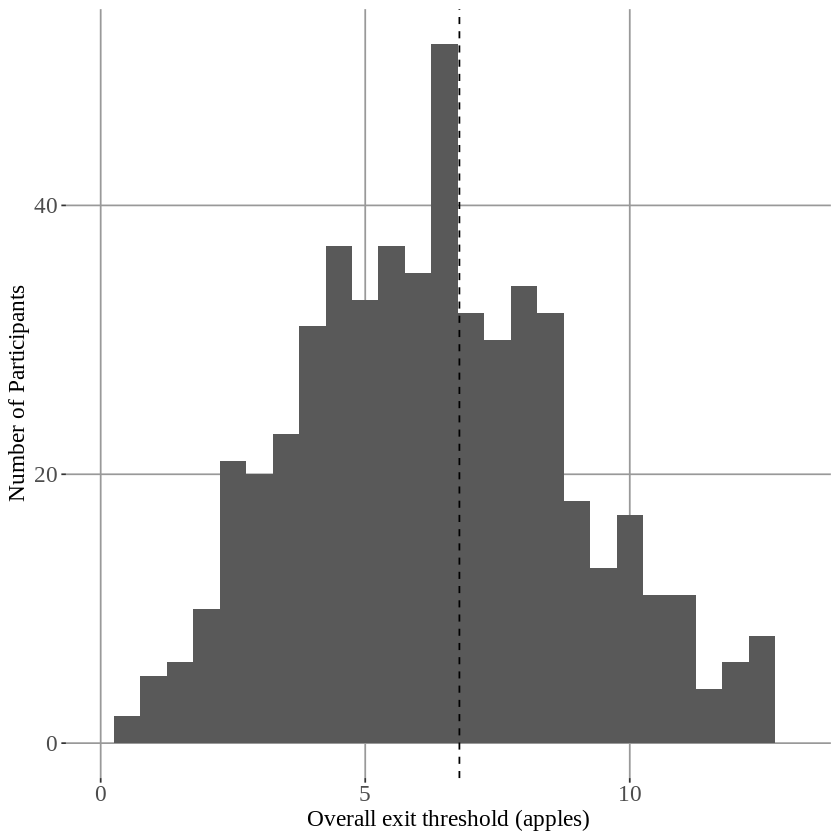

In [8]:
### Figure S2: Individual differences in overall threshold.
lmer_threshold_subj_experiment_1 <- lmer(
  'expectedReward ~ 1 + (1 | subject_id)',
  data = choiceData_experiment_1 %>%
    filter(decision == "exit",
    effort_level == "low"))
exit_threshold_subj_experiment_1 <- ranef(lmer_threshold_subj_experiment_1)$subject_id %>%
  mutate(subject_id = row.names(.)) %>%
  rename(threshold_subj = "(Intercept)") %>%
  mutate(Threshold = threshold_subj + fixef(lmer_threshold_subj_experiment_1))
threshold_subj_max <- max(max(exit_threshold_subj_experiment_1$Threshold))
p_threshold_subj_experiment_1 <- ggplot(data = exit_threshold_subj_experiment_1) +
  geom_histogram(aes(Threshold),
                 binwidth = 0.5) +
  labs(y = "Number of Participants",
       x = "Overall exit threshold (apples)") +
  scale_y_continuous(breaks = scales::breaks_pretty(n = 3)) +
  scale_x_continuous(limits = c(0,
                                threshold_subj_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_vline(aes(xintercept = 6.78),
             linetype = "dashed")
print(p_threshold_subj_experiment_1)

# Question 3: why some individuals have very low or high exit thresholds?
There were large individual differences in foraging strategy!

What reasons can you come up with for why some individuals have very high exit thresholds? Or very low thresholds? Can you think of any ways to test your account?

## Recovering exit thresholds from simulated data
Beyond examining the best threshold, we can simulate the observed distribution of thresholds across participants, and see how well we can recover them using the same method we do for observed data. The code below will generate simulated data for each participant based on their overall exit threshold estimated by regression.


In [9]:
# Define the evaluate_threshold function
simulate_data <- function(thresh, d, h, mu, sigma, a, b, time) {
  # Initialize variables
  r_max <- mu + 5
  E_kappa <- a / (a + b)
  # track observed choices and rewards
  choices <- c()
  rewards <- c()
  kappas <- c()
  harvest_counters <- c()
  # Iterate for the specified amount of time
  t_counter <- 0
  r_counter <- 0
  harvest_counter <- 0
  # Simulate foraging process
  while ((t_counter + h) <= time) {
    if (harvest_counter == 0) {
      # Get initial reward from a normal distribution
      r <- rnorm(1, mean = mu, sd = sigma)
      if (r > r_max) {
        r <- r_max
      }
      t_counter <- t_counter + h
      r_counter <- r_counter + r
      harvest_counter <- harvest_counter + 1
      choices <- c(choices, "harvest")
      rewards <- c(rewards, r)
      kappas <- c(kappas, NA)
      harvest_counters <- c(harvest_counters, harvest_counter)
    } else {
      # Calculate expected reward based on decay rate
      Er <- E_kappa * r
      if (Er < thresh) {
        # If expected reward is below threshold, exit
        t_counter <- t_counter + d
        harvest_counter <- 0
        choices <- c(choices, "exit")
        rewards <- c(rewards, 0)
        kappas <- c(kappas, NA)
      } else {
        # If expected reward is above threshold, continue harvesting
        kappa <- rbeta(1, shape1 = a, shape2 = b)
        r <- kappa * r
        r_counter <- r_counter + r
        t_counter <- t_counter + h
        harvest_counter <- harvest_counter + 1
        kappas <- c(kappas, kappa)
        choices <- c(choices, "harvest")
        rewards <- c(rewards, r)
      }
      harvest_counters <- c(harvest_counters, harvest_counter)
    }
  }
  # Calculate average reward rate and number of exits
  data.frame(
    decision = choices,
    reward = rewards,
    travel_duration = d,
    choice_duration = h,
    start_reward_mean = mu,
    start_reward_sd = sigma,
    depletion = kappas,
    depletion_rate_mean = E_kappa,
    depletion_rate_alpha = a,
    depletion_rate_beta = b,
    round_duration = time,
    simulation_threshold = thresh,
    harvest_counter = harvest_counters
    );
}

choiceData_experiment_1_simulated <- c()
for (s in 1:dim(exit_threshold_subj_experiment_1)[1]){
  simulated_participant <- simulate_data(
    exit_threshold_subj_experiment_1$Threshold[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward))
  choiceData_experiment_1_simulated <- bind_rows(choiceData_experiment_1_simulated,
                                      simulated_participant)
}
head(choiceData_experiment_1_simulated,25)


,decision,reward,travel_duration,choice_duration,start_reward_mean,start_reward_sd,depletion,depletion_rate_mean,depletion_rate_alpha,depletion_rate_beta,round_duration,simulation_threshold,harvest_counter,subject_id,last_reward,second_last_reward,expectedReward
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,harvest,13.977389,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,1,08aiu2bm6t15qij5826jxz50,NA,NA,NA
2,harvest,11.844424,8.33,2,15,1,0.8473989,0.88,14.90873,2.033008,480,8.157199,2,08aiu2bm6t15qij5826jxz50,13.977389,NA,NA
3,harvest,9.489083,8.33,2,15,1,0.8011435,0.88,14.90873,2.033008,480,8.157199,3,08aiu2bm6t15qij5826jxz50,11.844424,13.977389,11.361598
4,harvest,8.718919,8.33,2,15,1,0.9188368,0.88,14.90873,2.033008,480,8.157199,4,08aiu2bm6t15qij5826jxz50,9.489083,11.844424,9.386744
5,exit,0.000000,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,0,08aiu2bm6t15qij5826jxz50,8.718919,9.489083,8.011521
6,harvest,15.831131,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,8.157199,1,08aiu2bm6t15qij5826jxz50,0.000000,8.718919,0.000000
7,harvest,14.361260,8.33,2,15,1,0.9071531,0.88,14.90873,2.033008,480,8.157199,2,08aiu2bm6t15qij5826jxz50,15.831131,0.000000,6.965698
8,harvest,10.954371,8.33,2,15,1,0.7627723,0.88,14.90873,2.033008,480,8.157199,3,08aiu2bm6t15qij5826jxz50,14.361260,15.831131,13.284652
9,harvest,8.750242,8.33,2,15,1,0.7987900,0.88,14.90873,2.033008,480,8.157199,4,08aiu2bm6t15qij5826jxz50,10.954371,14.361260,11.138878


Now that we have the simulated data, we will fit the same regression model and plot the individual differences in overall exit threshold.  

Linear mixed model fit by REML ['lmerMod']
Formula: expectedReward ~ 1 + (1 | subject_id)
   Data: choiceData_experiment_1_simulated %>% filter(decision == "exit")

REML criterion at convergence: 32511.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.6844 -0.2842 -0.0212  0.3070  4.7680 

Random effects:
 Groups     Name        Variance Std.Dev.
 subject_id (Intercept) 6.3315   2.5162  
 Residual               0.7828   0.8848  
Number of obs: 11479, groups:  subject_id, 537

Fixed effects:
            Estimate Std. Error t value
(Intercept)   6.4049     0.1089    58.8

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


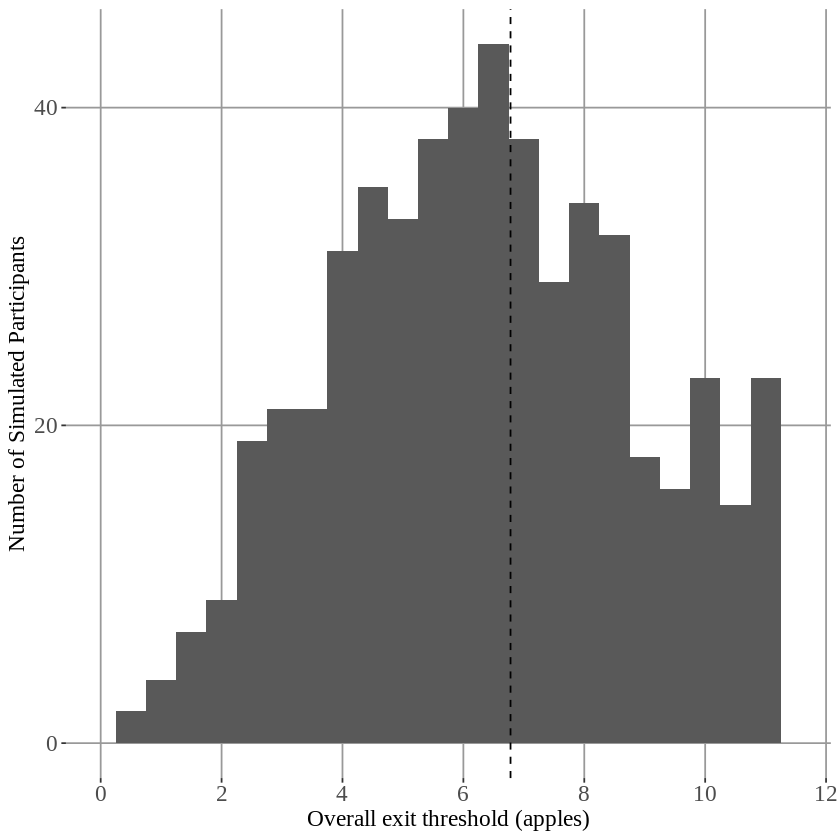

In [12]:
lmer_threshold_subj_experiment_1_simulated <- lmer(
  'expectedReward ~ 1 + (1 | subject_id)',
  data = choiceData_experiment_1_simulated %>%
    filter(decision == "exit"))
summary(lmer_threshold_subj_experiment_1_simulated)

exit_threshold_subj_experiment_1_simulated <- ranef(lmer_threshold_subj_experiment_1_simulated)$subject_id %>%
  mutate(subject_id = row.names(.)) %>%
  rename(threshold_subj = "(Intercept)") %>%
  mutate(Threshold = threshold_subj + fixef(lmer_threshold_subj_experiment_1_simulated))
threshold_subj_max <- max(max(exit_threshold_subj_experiment_1_simulated$Threshold))
p_threshold_subj_experiment_1_simulated <- ggplot(data = exit_threshold_subj_experiment_1_simulated) +
  geom_histogram(aes(Threshold),
                 binwidth = 0.5) +
  labs(y = "Number of Simulated Participants",
       x = "Overall exit threshold (apples)") +
  scale_y_continuous(breaks = scales::breaks_pretty(n = 3)) +
  scale_x_continuous(limits = c(0,
                                threshold_subj_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_vline(aes(xintercept = 6.78),
             linetype = "dashed")
print(p_threshold_subj_experiment_1_simulated)

The distribution looks quite similar! In the code below we can directly compare the true thresholds to the simulated thresholds.

,subject_id,Threshold,Threshold_simulated
,<chr>,<dbl>,<dbl>
1,08aiu2bm6t15qij5826jxz50,8.157199,8.200738
2,09j932f828pn7h7bozp9mpnl,5.682763,5.650956
3,0ax9htcbhfi3ncsospqzwjx2,8.781321,8.976749
4,0e6zivqly335lojgb4c6606t,7.287457,7.245085
5,0fawro1pivqnh4lem4ayf4o0,3.457076,3.515997
6,0jru2culdqol34gpc90oigjn,7.270041,7.487507


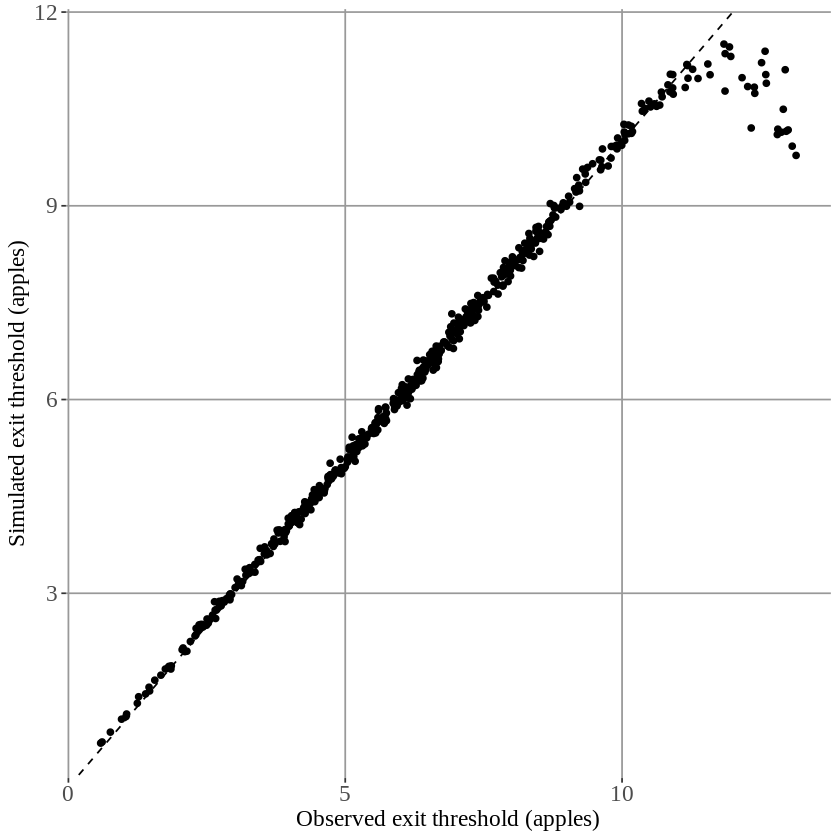

In [24]:
exit_threshold_compare_real_simulated <- exit_threshold_subj_experiment_1 %>%
  select(subject_id,
Threshold) %>%
  full_join(exit_threshold_subj_experiment_1_simulated %>%
  select(subject_id,
Threshold_simulated = Threshold),
by = "subject_id")
head(exit_threshold_compare_real_simulated)

ggplot(data = exit_threshold_compare_real_simulated,
aes(x = Threshold,
  y = Threshold_simulated)) +
  geom_point() +
  labs(y = "Simulated exit threshold (apples)",
       x = "Observed exit threshold (apples)") +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_abline(aes(intercept = 0,
                  slope = 1),
             linetype = "dashed")

Recovery looks pretty good, except for very high exit thresholds. Can you think of any reasons this might be? Hint: patch decay is non-linear... Bonus exercise: repeat these steps but use the 'expectedReward_log' variable.  

# Effect of effort on foraging behavior

Lastly, we are going to examine the effect of the effortful travel tasks on foraging behavior

`summarise()` has grouped output by 'effort_level', 'travel_task'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'effort_level'. You can override using the
`.groups` argument.


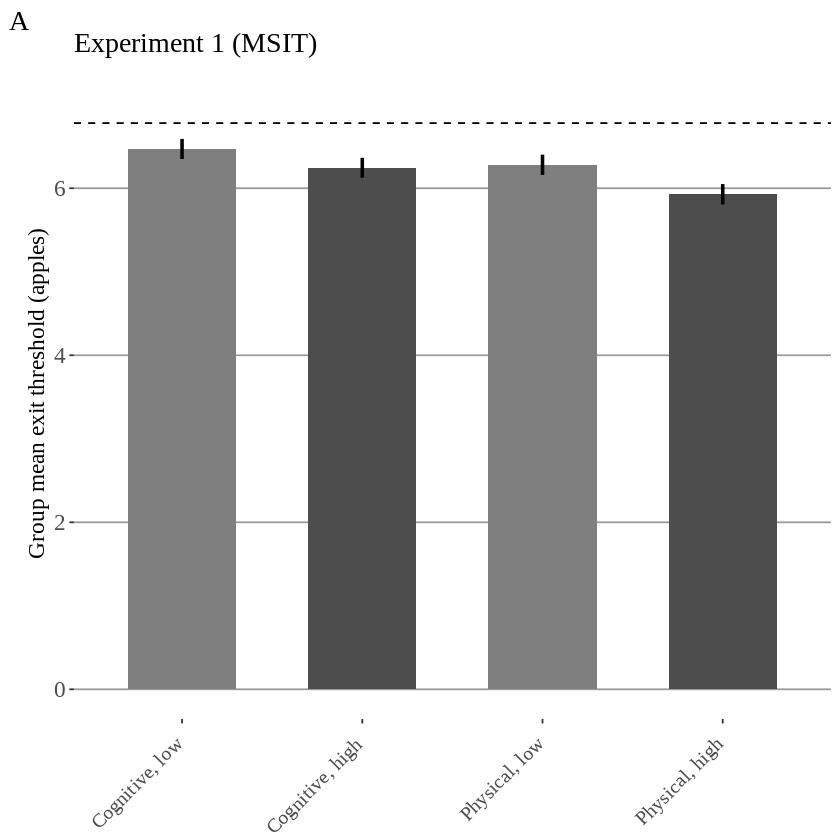

In [15]:
### Figure S1: Group level exit thresholds by Experiment
threshold_by_effort_type_subj_experiment_1 <- choiceData_experiment_1 %>%
  filter(decision == "exit") %>%
  group_by(effort_level, travel_task, subject_id) %>%
  summarise(Threshold = mean(expectedReward, na.rm = TRUE),
            Threshold_sd = sd(expectedReward, na.rm = TRUE))

threshold_by_effort_type_experiment_1 <- threshold_by_effort_type_subj_experiment_1 %>%
  summarise(threshold = mean(Threshold, na.rm = TRUE),
            nsubj = n(),
            threshold_sem = sd(Threshold, na.rm = TRUE)/sqrt(nsubj)) %>%
  mutate(threshold_sem = ifelse(is.na(threshold_sem), 0, threshold_sem),
         block_str = case_when(effort_level == "low" & travel_task == "msit" ~
                                 "Cognitive, low",
                               effort_level == "high" & travel_task == "msit" ~
                                 "Cognitive, high",
                               effort_level == "low" & travel_task == "bp" ~
                                 "Physical, low",
                               effort_level == "high" & travel_task == "bp" ~
                                 "Physical, high"),
         block_str = factor(block_str,
                            levels = c("Cognitive, low",
                                       "Cognitive, high",
                                       "Physical, low",
                                       "Physical, high")),
         experiment = "Experiment 1")

threshold_max <- max(threshold_by_effort_type_experiment_1$threshold +
                    threshold_by_effort_type_experiment_1$threshold_sem) + 0.5

p_threshold_experiment_1 <- ggplot(data = threshold_by_effort_type_experiment_1) +
  geom_bar(aes(x = block_str,
               y = threshold,
               fill = effort_level),
           stat = "identity",
           position = position_dodge(),
           width = 0.6,
           size = 2) +
  geom_hline(aes(yintercept = 6.78),
             linetype = "dashed") +
  scale_fill_manual(values=c("grey30",
                             "grey50")) +
      geom_errorbar(aes(x = block_str,
                      ymax = threshold + threshold_sem,
                      ymin = threshold - threshold_sem),
                      width = 0,
                      size = 1,
                      position = position_dodge(width=0.1),
                      color = "black") +
  labs(title = "Experiment 1 (MSIT)",
       y = "Group mean exit threshold (apples)",
       fill = "Effort level",
       tags = "A") +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text.y = element_text(size = 14),
        axis.text.x = element_text(size = 12,
                                   angle = 45,
                                   vjust = 1,
                                   hjust = 1.1),
        axis.title.x = element_blank(),
        legend.position = "none",
        panel.background = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_y_continuous(limits = c(0, threshold_max),
                     breaks = scales::breaks_pretty())
print(p_threshold_experiment_1)

The prediction was that exit thresholds would be lower in high relative to low effort conditions, it does look like that is the case, but we can plot it more directly by taking the difference in exit thresholds per effort level, per participant.

`summarise()` has grouped output by 'subject_id', 'travel_task'. You can
override using the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


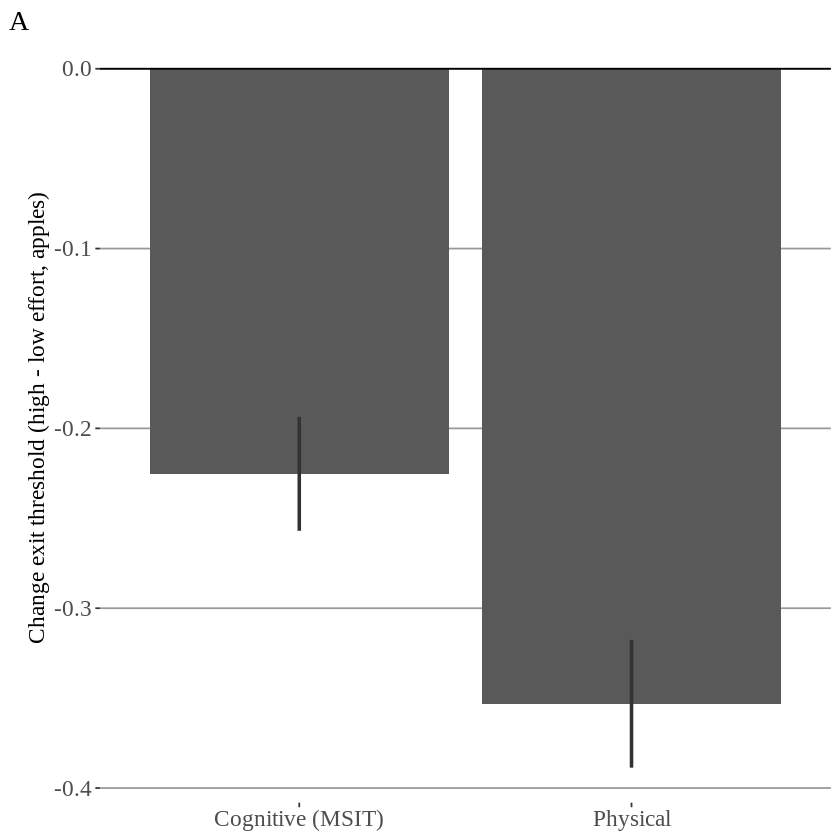

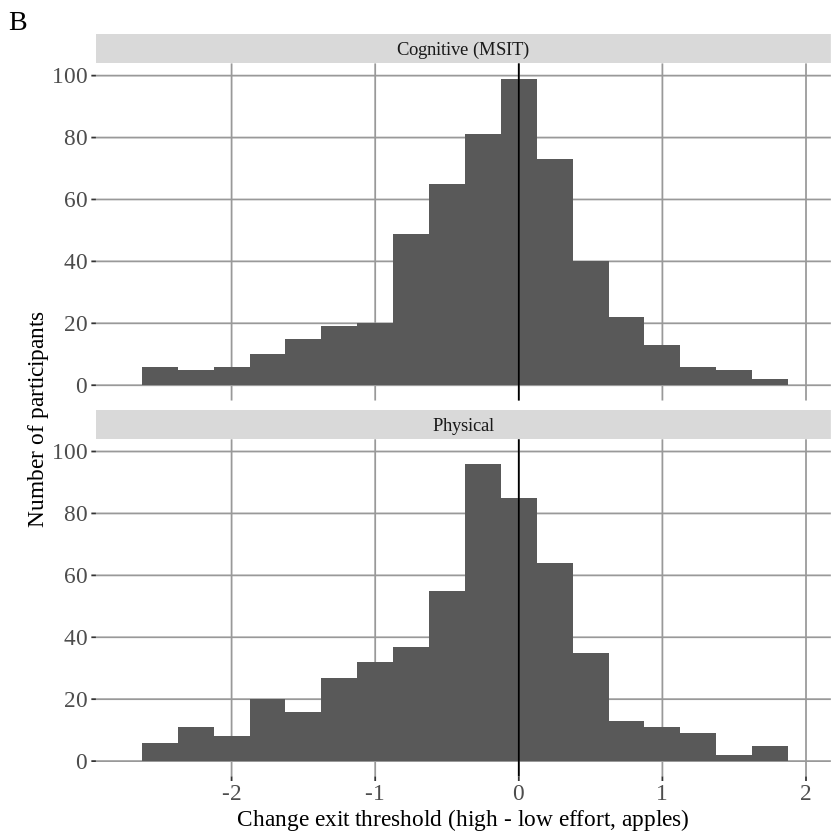

In [16]:
### Figure 3: Change in exit thresholds by effort condition.
# participant
change_exit_threshold_participant_experiment_1 <- choiceData_experiment_1 %>%
  filter(decision == "exit") %>%
  group_by(subject_id, travel_task, effort_level) %>%
  summarise(exit_threshold = mean(expectedReward, na.rm = TRUE)) %>%
  pivot_wider(names_from = c("travel_task",
                             "effort_level"),
              values_from = c("exit_threshold")) %>%
  mutate(change_exit_msit = msit_high - msit_low,
         change_exit_bp = bp_high - bp_low) %>%
  ungroup() %>%
  select(subject_id,
         change_exit_msit,
         change_exit_bp) %>%
  pivot_longer(-subject_id) %>%
  mutate(effort_type = case_when(name == "change_exit_msit" ~ "Cognitive (MSIT)",
                                 name == "change_exit_bp" ~ "Physical"),
         effort_type = factor(effort_type,
                              levels = c("Cognitive (MSIT)",
                                         "Physical")))
change_exit_threshold_min <- min(change_exit_threshold_participant_experiment_1$value)
change_exit_threshold_max <- max(change_exit_threshold_participant_experiment_1$value)

# group
nsubj_experiment_1 <- length(unique(choiceData_experiment_1$subject_id))
change_exit_threshold_group_experiment_1 <- change_exit_threshold_participant_experiment_1 %>%
  group_by(effort_type) %>%
  summarise(change_threshold_group_mean = mean(value),
            change_threshold_group_sem = sd(value)/sqrt(nsubj_experiment_1))
change_threshold_group_min <- min(change_exit_threshold_group_experiment_1$change_threshold_group_mean -
                         change_exit_threshold_group_experiment_1$change_threshold_group_sem)
# plot
p_change_exit_threshold_group_experiment_1 <- ggplot(
  data = change_exit_threshold_group_experiment_1,
       aes(y = change_threshold_group_mean, x = effort_type)) +
  geom_bar(stat = "identity", position = position_dodge(width=0.9)) +
  labs(y = "Change exit threshold (high - low effort, apples)",
       tag = "A") +
    geom_errorbar(aes(ymax = change_threshold_group_mean + change_threshold_group_sem,
                    ymin= change_threshold_group_mean - change_threshold_group_sem),
                  width = 0,
                  size = 1,
                  position = position_dodge(width=0.9),
                  color = "grey20") +
  geom_hline(yintercept = 0,
             color = "black") +
  scale_y_continuous(limits = c(change_threshold_group_min, 0),
                     breaks = scales::breaks_pretty()) +
  theme(text = element_text(size = 14,
                            family = "Times New Roman"),
        axis.text = element_text(size = 14),
        axis.title.x = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                          linetype = 'solid',
                                colour = "grey60"),
        panel.grid.major.x = element_blank())
print(p_change_exit_threshold_group_experiment_1)

p_change_exit_threshold_participant_experiment_1 <- ggplot(
  data = change_exit_threshold_participant_experiment_1) +
  geom_histogram(aes(value),
                 binwidth = 0.25) +
  facet_wrap(~ effort_type,
             ncol = 1) +
  labs(y = "Number of participants",
       x = "Change exit threshold (high - low effort, apples)",
       tag = "B") +
  scale_y_continuous(breaks = scales::breaks_pretty()) +
  scale_x_continuous(limits = c(change_exit_threshold_min,
                                change_exit_threshold_max),
                     breaks = scales::breaks_pretty()) +
  theme(text=element_text(size = 14,
                          family = "Times New Roman"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                          linetype = 'solid',
                                colour = "grey60")) +
  geom_vline(xintercept = 0)
print(p_change_exit_threshold_participant_experiment_1)

# Question 4: positive values for change in exit threshold
We predicted participants would have a lower exit threshold in the high versus low effort condition. Here we can see that some participants showed a higher exit threshold in the high relative to low effort condition. What hypotheses can you come up with for why participants did this? Can you think of an analysis you can do in this study to test your account? Is there an experiment you could design to test your hypothesis?

#Question 5: How well can we recover the change in exit threshold?
It seems like we can recover overall exit thresholds well, but to get the effect of effort on foraging behavior we have to be able to detect changes in exit thresholds. Next we will calculate the change in exit threshold from high to low cognitive effort and simulate it.

In [23]:
# Extract the threshold for high and low effort for each participant,
# simulate the data, and compare the change in exit threshold for the simulated versus empirical data.
lmer_change_threshold_subj_experiment_1 <- lmer(
  'expectedReward ~ 1 + isMatching + (1 + isMatching | subject_id)',
  data = choiceData_experiment_1 %>%
    filter(decision == "exit",
           travelTask == "MSIT"))
change_exit_threshold_subj_experiment_1 <- ranef(lmer_change_threshold_subj_experiment_1)$subject_id %>%
  transmute(subject_id = row.names(.),
         threshold_high_effort = `(Intercept)`+fixef(lmer_change_threshold_subj_experiment_1)[1],
         threshold_change = isMatching+fixef(lmer_change_threshold_subj_experiment_1)[2],
         threshold_low_effort = threshold_high_effort+threshold_change)
head(change_exit_threshold_subj_experiment_1)

choiceData_experiment_1_change_threshold_simulated <- c()
for (s in 1:dim(change_exit_threshold_subj_experiment_1)[1]){
  simulated_low_effort_participant <- simulate_data(
    change_exit_threshold_subj_experiment_1$threshold_low_effort[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = change_exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward),
            isMatching = 1)
  simulated_high_effort_participant <- simulate_data(
    change_exit_threshold_subj_experiment_1$threshold_high_effort[s], 8.33, 2, 15, 1, 14.90873, 2.033008, 480) %>%
      mutate(subject_id = change_exit_threshold_subj_experiment_1$subject_id[s],
            last_reward = lag(reward),
            second_last_reward = lag(last_reward),
            expectedReward = ((last_reward+second_last_reward)/2)*depletion_rate_mean,
            expectedReward = ifelse(harvest_counter == 1,
                                    last_reward*depletion_rate_mean,
                                    expectedReward),
            isMatching = 0)
  choiceData_experiment_1_change_threshold_simulated <- bind_rows(choiceData_experiment_1_change_threshold_simulated,
                                      simulated_low_effort_participant) %>%
                                        bind_rows(., simulated_high_effort_participant)
}
head(choiceData_experiment_1_change_threshold_simulated,25)

,subject_id,threshold_high_effort,threshold_change,threshold_low_effort
,<chr>,<dbl>,<dbl>,<dbl>
08aiu2bm6t15qij5826jxz50,08aiu2bm6t15qij5826jxz50,7.525899,-0.43439470,7.091504
09j932f828pn7h7bozp9mpnl,09j932f828pn7h7bozp9mpnl,4.384694,0.81643559,5.201129
0ax9htcbhfi3ncsospqzwjx2,0ax9htcbhfi3ncsospqzwjx2,8.401473,0.27353324,8.675006
0e6zivqly335lojgb4c6606t,0e6zivqly335lojgb4c6606t,7.414251,-0.13104155,7.283210
0fawro1pivqnh4lem4ayf4o0,0fawro1pivqnh4lem4ayf4o0,2.747724,0.89729533,3.645020
0jru2culdqol34gpc90oigjn,0jru2culdqol34gpc90oigjn,7.499753,-0.04907372,7.450679


,decision,reward,travel_duration,choice_duration,start_reward_mean,start_reward_sd,depletion,depletion_rate_mean,depletion_rate_alpha,depletion_rate_beta,round_duration,simulation_threshold,harvest_counter,subject_id,last_reward,second_last_reward,expectedReward,isMatching
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,harvest,14.527316,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,7.091504,1,08aiu2bm6t15qij5826jxz50,NA,NA,NA,1
2,harvest,13.134710,8.33,2,15,1,0.9041388,0.88,14.90873,2.033008,480,7.091504,2,08aiu2bm6t15qij5826jxz50,14.527316,NA,NA,1
3,harvest,12.587041,8.33,2,15,1,0.9583037,0.88,14.90873,2.033008,480,7.091504,3,08aiu2bm6t15qij5826jxz50,13.134710,14.527316,12.171292,1
4,harvest,9.850392,8.33,2,15,1,0.7825820,0.88,14.90873,2.033008,480,7.091504,4,08aiu2bm6t15qij5826jxz50,12.587041,13.134710,11.317571,1
5,harvest,9.330708,8.33,2,15,1,0.9472423,0.88,14.90873,2.033008,480,7.091504,5,08aiu2bm6t15qij5826jxz50,9.850392,12.587041,9.872471,1
6,harvest,9.039895,8.33,2,15,1,0.9688326,0.88,14.90873,2.033008,480,7.091504,6,08aiu2bm6t15qij5826jxz50,9.330708,9.850392,8.439685,1
7,harvest,8.434851,8.33,2,15,1,0.9330696,0.88,14.90873,2.033008,480,7.091504,7,08aiu2bm6t15qij5826jxz50,9.039895,9.330708,8.083066,1
8,harvest,7.790638,8.33,2,15,1,0.9236248,0.88,14.90873,2.033008,480,7.091504,8,08aiu2bm6t15qij5826jxz50,8.434851,9.039895,7.688888,1
9,exit,0.000000,8.33,2,15,1,NA,0.88,14.90873,2.033008,480,7.091504,0,08aiu2bm6t15qij5826jxz50,7.790638,8.434851,7.139216,1


How well can we recover the change in exit threshold? Write code to run the mixed effects regression on the simulated data, and plot the observed change in exit threshold against the simulated change in exit threshold.

,subject_id,threshold_high_effort,threshold_change,threshold_low_effort
,<chr>,<dbl>,<dbl>,<dbl>
08aiu2bm6t15qij5826jxz50,08aiu2bm6t15qij5826jxz50,7.439586,-0.28729232,7.152294
09j932f828pn7h7bozp9mpnl,09j932f828pn7h7bozp9mpnl,4.576419,0.75803724,5.334456
0ax9htcbhfi3ncsospqzwjx2,0ax9htcbhfi3ncsospqzwjx2,8.415570,0.28923513,8.704805
0e6zivqly335lojgb4c6606t,0e6zivqly335lojgb4c6606t,7.454113,-0.23179609,7.222317
0fawro1pivqnh4lem4ayf4o0,0fawro1pivqnh4lem4ayf4o0,2.920338,0.67775006,3.598088
0jru2culdqol34gpc90oigjn,0jru2culdqol34gpc90oigjn,7.516671,-0.06074004,7.455931


,subject_id,threshold_high_effort,threshold_change,threshold_high_effort_simulated,threshold_change_simulated
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,08aiu2bm6t15qij5826jxz50,7.525899,-0.43439470,7.439586,-0.28729232
2,09j932f828pn7h7bozp9mpnl,4.384694,0.81643559,4.576419,0.75803724
3,0ax9htcbhfi3ncsospqzwjx2,8.401473,0.27353324,8.415570,0.28923513
4,0e6zivqly335lojgb4c6606t,7.414251,-0.13104155,7.454113,-0.23179609
5,0fawro1pivqnh4lem4ayf4o0,2.747724,0.89729533,2.920338,0.67775006
6,0jru2culdqol34gpc90oigjn,7.499753,-0.04907372,7.516671,-0.06074004


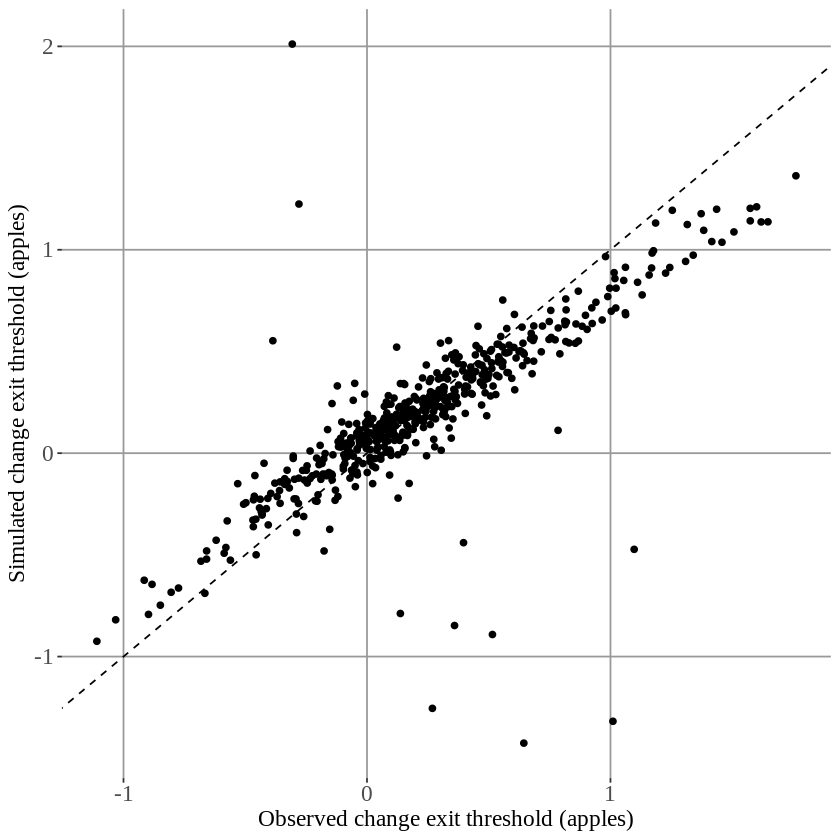

In [25]:
# ANSWER:
lmer_change_threshold_subj_experiment_1_simulated <- lmer(
  'expectedReward ~ 1 + isMatching + (1 + isMatching | subject_id)',
  data = choiceData_experiment_1_change_threshold_simulated %>%
    filter(decision == "exit"))
change_exit_threshold_subj_experiment_1_simulated <- ranef(lmer_change_threshold_subj_experiment_1_simulated)$subject_id %>%
  transmute(subject_id = row.names(.),
         threshold_high_effort = `(Intercept)`+fixef(lmer_change_threshold_subj_experiment_1_simulated)[1],
         threshold_change = isMatching+fixef(lmer_change_threshold_subj_experiment_1_simulated)[2],
         threshold_low_effort = threshold_high_effort+threshold_change)
head(change_exit_threshold_subj_experiment_1_simulated)

change_exit_threshold_compare_real_simulated <- change_exit_threshold_subj_experiment_1 %>%
  select(subject_id,
         threshold_high_effort,
         threshold_change) %>%
  full_join(change_exit_threshold_subj_experiment_1_simulated %>%
            select(subject_id,
            threshold_high_effort_simulated = threshold_high_effort,
            threshold_change_simulated = threshold_change),
by = "subject_id")
head(change_exit_threshold_compare_real_simulated)

ggplot(data = change_exit_threshold_compare_real_simulated,
aes(x = threshold_change,
  y = threshold_change_simulated)) +
  geom_point() +
  labs(y = "Simulated change exit threshold (apples)",
       x = "Observed change exit threshold (apples)") +
  theme(text=element_text(size = 14,
                          family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  geom_abline(aes(intercept = 0,
                  slope = 1),
             linetype = "dashed")

# Hierarchal Bayesian MVT model

In order to recover effort costs, we went beyond just estimating exit thresholds, and built an MVT model to predict trial by trial foraging choices. First we will load data formatted for the model, the OSF repository includes code to create this data.

In [2]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/foraging_mvt_stan_data_experiment_1.csv.zip"
download.file(urlfile, destfile = "foraging_mvt_stan_data_experiment_1.zip")
unzip("foraging_mvt_stan_data_experiment_1.zip")
data <- readr::read_csv("foraging_mvt_stan_data_experiment_1.csv")
head(data)
# stan requires a list as input
foraging_experiment_1_standata <- list(NS = unique(data$NS),
                               K = dim(data)[1],
                               choose_stay = data$choose_stay,
                               which_S = data$which_S,
                               total_reward = data$total_reward,
                               total_harvest_periods = data$total_harvest_periods,
                               number_trees = data$number_trees,
                               expected_reward = data$expected_reward,
                               is_Matching = data$is_Matching,
                               is_Mismatching = data$is_Mismatching,
                               is_small = data$is_small,
                               is_large = data$is_large)

Rows: 344217 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): subject_id
dbl (13): NS, NT, MT, which_S, choose_stay, total_reward, total_harvest_peri...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


NS,NT,MT,which_S,choose_stay,total_reward,total_harvest_periods,number_trees,expected_reward,is_Matching,is_Mismatching,is_small,is_large,subject_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
537,607,848,1,1,1383.913,240,24,2.385508,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,12.162508,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,0,1383.913,240,24,11.557546,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,5.476291,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,12.083010,0,0,1,0,08aiu2bm6t15qij5826jxz50
537,607,848,1,1,1383.913,240,24,11.127353,0,0,1,0,08aiu2bm6t15qij5826jxz50


Here is the model code, don't worry about understanding all of it, we will zoom in on the most important parts:
```
data {
  int NS; // number of particiants
  int K; // length of all trials for all participants
  array[K] int choose_stay; // whether participant exits the patch (0) or not (1)
  array[K] int<lower=1, upper=NS> which_S;
  vector[K] total_reward; // total rewards per block type
  vector[K] total_harvest_periods; // time spent per block type
  vector[K] number_trees; // how many trees visited per block type
  vector[K] expected_reward; // reward expected on a trial
  vector[K] is_Matching; // 1 = congruent trial block, 0 = not
  vector[K] is_Mismatching; // 1 = interference trial block, 0 = not
  vector[K] is_small; // 1 = physical low efffort block, 0 = not
  vector[K] is_large; // 1 = physical high efffort block, 0 = not
}

transformed data {
  // fixed effects prior ~ N(X_mu_prior, X_s_prior)
  // [1] = log inv_temp
  // [2] = cost_congruent
  // [3] = cost_interference
  // [4] = cost_small
  // [5] = cost_large
  vector[5] gam_mu_prior = [0, 0, 0, 0, 0]';     // mean of fixed effect prior
  vector[5] gam_s_prior  = [0.5, 40, 30, 40, 30]'; // sd of fixed effect prior
  vector[5] tau_mu_prior = [0.5, 20, 15, 20, 15]'; // mean of random variance prior
  vector[5] tau_s_prior  = [0.5, 20, 15, 20, 15]'; // sd of random variance prior
}

parameters {
  // [1] = log inv_temp
  // [2] = cost_congruent
  // [3] = cost_interference
  // [4] = cost_small
  // [5] = cost_large
  // session mean parameters
  vector[5] mu;           //  fixed effects
  vector<lower=0>[5] tau; // spread of random effects
  // reparameterization, all random effects in a single matrix
  matrix[5, NS] U_pr;            // uncorreleated random effects
  cholesky_factor_corr[5] L_u;  // decomposition of corr matrix to lower triangular matrix
}

transformed parameters {
  matrix[NS, 5] U;      // random effects
  matrix[NS, 5] beta_s; // fixed + random effects
  // transform random effects
  // these have dimensions NS x Number of parameters
  // for example,
  // U[1,1]   = random effect inv. temp for subject 1
  // U[10, 3] = random effect of cost incongruent for subject 10
  U = (diag_pre_multiply(tau, L_u) * U_pr)';
  
  // compute fixed + random effect for each subject      
  for(i in 1:NS) {
  	for(p in 1:5) {
    beta_s[i,p] = mu[p] + U[i,p];
    }
  }
}

model {
  // priors (adjusted for bounds)
  target += normal_lpdf(mu  | gam_mu_prior, gam_s_prior);
  target += normal_lpdf(tau | tau_mu_prior, tau_s_prior) - 5*normal_lccdf(0 | tau_mu_prior, tau_s_prior);
  target += lkj_corr_cholesky_lpdf(L_u | 1);
  target += std_normal_lpdf(to_vector(U_pr));
  // likelihood
    choose_stay ~ bernoulli_logit((exp(beta_s[which_S, 1]))
                                .* (expected_reward
                                    - is_Matching
                                      .* ((total_reward
                                           - beta_s[which_S, 2]
                                             .* number_trees)
                                          ./ total_harvest_periods)
                                    - is_Mismatching
                                      .* ((total_reward
                                           - (beta_s[which_S, 2]
                                              + (beta_s[which_S, 3]))
                                             .* number_trees)
                                          ./ total_harvest_periods)
                                    - is_small
                                      .* ((total_reward
                                           - beta_s[which_S, 4]
                                             .* number_trees)
                                          ./ total_harvest_periods)
                                    - is_large
                                      .* ((total_reward
                                           - (beta_s[which_S, 4]
                                              + (beta_s[which_S, 5]))
                                             .* number_trees)
                                          ./ total_harvest_periods)));
}
  
generated quantities {
  // "recompose" Choleksy to corr matrix
  corr_matrix[5] rho = L_u * L_u';
}

// "recompose" Choleksy to corr matrix
  corr_matrix[5] rho = L_u * L_u';
}
```

The MVT rule is in this code segment:

```
// likelihood
    choose_stay ~ bernoulli_logit((exp(beta_s[which_S, 1]))
                                .* (expected_reward
                                    - is_Matching
                                      .* ((total_reward
                                           - beta_s[which_S, 2]
                                             .* number_trees)
                                          ./ total_harvest_periods)
                                    - is_Mismatching
                                      .* ((total_reward
                                           - (beta_s[which_S, 2]
                                              + (beta_s[which_S, 3]))
                                             .* number_trees)
                                          ./ total_harvest_periods)
```

For each foraging trial, model compares the expected reward on the next harvest (```expected_reward```), defined as the average of the previous harvest and the product of the previous harvest with the mean depletion rate (0.88)) against the overall average reward rate for a condition (effort level/type, here indicated by the variables ```is_Matching, is_Mismatching, is_small, is_large```), using a softmax function (with inverse temperature parameter, ```beta_s[which_S, 1]```) to make a choice (stay or exit). The cost of travel in high effort blocks (```beta_s[which_S, 3]``` and ```beta_s[which_S, 5]```) was expressed as the marginal increase in cost of travel (```beta_s[which_S, 2]+beta_s[which_S, 3]``` and ```beta_s[which_S, 4]+beta_s[which_S, 5]```) from low to high effort. Defining this cost as a difference measure controls for any additional biases individual participants may have which are common to both conditions (i.e., consistently high exit thresholds for some participants and low thresholds for others). The conditions are (```is_Matching, is_Mismatching, is_small, is_large```). The parameters of greatest interest are cognitive effort cost ```beta_s[which_S, 3]``` and physical effort cost ```beta_s[which_S, 5]```.

## Results from pre-fitted model
The model can take a significant amount of time to run, so we will load in a pre-fitted models.

In [26]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/cmdstan_samples_allsubs_experiment_1.tsv.gz"
download.file(urlfile, destfile = "/content/cmdstan_samples_allsubs_experiment_1.tsv.gz")
# load pre-fitted model
cost_travel_stan_fit_experiment_1 <- data.table::fread("/content/cmdstan_samples_allsubs_experiment_1.tsv.gz")
cost_travel_fit_vars <- c("inv_temp",
                          "cost_matching",
                          "cost_mismatching",
                          "cost_small",
                          "cost_large")
cost_travel_fit_vars_titles <- c("Inverse Tempurature",
                                "Cognitive Low Effort Travel Cost",
                                "Cognitive Effort Cost",
                                "Physical Low Effort Travel Cost",
                                "Physical Effort Cost")

## Group level posterior distributions

In [27]:
### Table S1: Group level posterior distributions.
cost_travel_stan_fit_group_experiment_1 <- cost_travel_stan_fit_experiment_1 %>%
    select(contains("beta_ms[")) %>%
    pivot_longer(everything(),
                 names_to = "params",
                 values_to = "params_val") %>%
    mutate(param_name = case_when(params == "beta_ms[1]" ~ cost_travel_fit_vars_titles[1],
                                  params == "beta_ms[2]" ~ cost_travel_fit_vars_titles[2],
                                  params == "beta_ms[3]" ~ cost_travel_fit_vars_titles[3],
                                  params == "beta_ms[4]" ~ cost_travel_fit_vars_titles[4],
                                  params == "beta_ms[5]" ~ cost_travel_fit_vars_titles[5]))
table_S1 <- cost_travel_stan_fit_group_experiment_1 %>%
  ungroup() %>%
  group_by(param_name) %>%
  summarise(mean = mean(params_val),
            lower = HDInterval::hdi(params_val, credMass = 0.95)[1],
            upper = HDInterval::hdi(params_val, credMass = 0.95)[2]) %T>%
  print()

# A tibble: 5 × 4
  param_name                         mean  lower   upper
  <chr>                             <dbl>  <dbl>   <dbl>
1 Cognitive Effort Cost             7.55   5.47    9.62 
2 Cognitive Low Effort Travel Cost 94.6   90.7    98.7  
3 Inverse Tempurature               0.260  0.239   0.283
4 Physical Effort Cost             13.5   10.9    15.9  
5 Physical Low Effort Travel Cost  99.8   95.4   104.   


On average we see that the group-level cognitive effort cost is 7.55 apples, and the physical effort cost is 13.5 apples in Experiment 1. How variable were those values?

## Individual differences in effort costs

Rows: 2685 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): param_name, param_name_str, subject_id
dbl (4): mean, lower, upper, HDIInterval_width

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


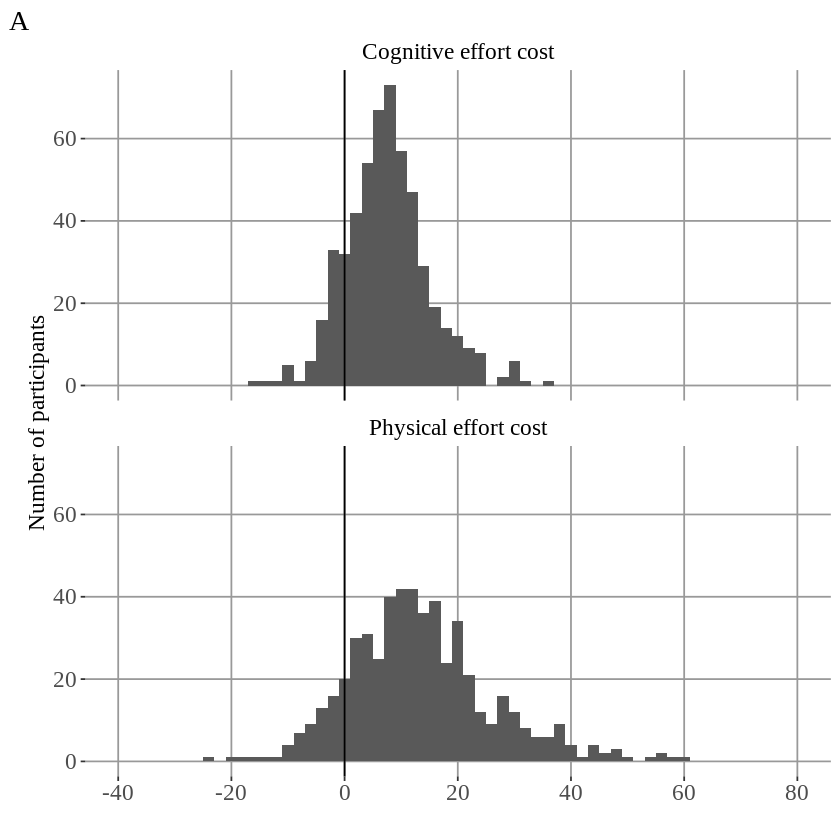

In [21]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/cost_travel_participant_experiment_1.csv.zip"
download.file(urlfile, destfile = "/content/cost_travel_participant_experiment_1.csv.zip")
unzip("/content/cost_travel_participant_experiment_1.csv.zip")
cost_travel_participant_experiment_1 <- readr::read_csv("cost_travel_participant_experiment_1.csv") %>%
   mutate(param_name_str = case_when(param_name == "cost_large" ~ "Physical effort cost",
                                    param_name == "cost_small" ~ "Physical low effort cost",
                                    param_name == "cost_matching" ~ "Cognitive low effort cost",
                                    param_name == "cost_mismatching" ~ "Cognitive effort cost",
                                    param_name == "inv_temp" ~ "Inverse tempurature"))
# histogram of individual differences in effort cost
cost_min <- min(filter(cost_travel_participant_experiment_1,
                      param_name == "cost_mismatching" |
                      param_name == "cost_large")$lower)
cost_max <- max(filter(cost_travel_participant_experiment_1,
                      param_name == "cost_mismatching" |
                      param_name == "cost_large")$upper)
p_cost_travel_histogram_experiment_1 <- ggplot(data = cost_travel_participant_experiment_1 %>%
         filter(param_name == "cost_mismatching" |
                param_name == "cost_large")) +
  geom_histogram(aes(mean),
                 binwidth = 2) +
  facet_wrap(~ param_name_str, ncol=1) +
  labs(y = "Number of participants",
       x = " ",
       tag = "A") +
  geom_vline(aes(xintercept = 0),
             color = "black") +
  theme(text = element_text(size = 14,
                            family = "serif"),
        axis.text = element_text(size = 14),
        strip.background = element_rect(fill="white"),
        strip.text = element_text(size = 14,
                                  colour="black"),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_y_continuous(breaks=scales::breaks_pretty()) +
  scale_x_continuous(breaks=scales::breaks_pretty(),
                     limits = c(cost_min,
                                cost_max))
print(p_cost_travel_histogram_experiment_1)

Again we see a nice spread of individual differences, and a proportion of participants who have negative effort costs, which in the paper we discuss within the context of 'effort-seeking'

## Correlation between individual differences in cognitive and physical effort costs
The model allowed us to directly estimate the correlation between cognitive and physical effort costs, we will plot the posterior distribution (likely values for the correlation, panel C), and a scatter plot of the individual-level paramters (panel B).

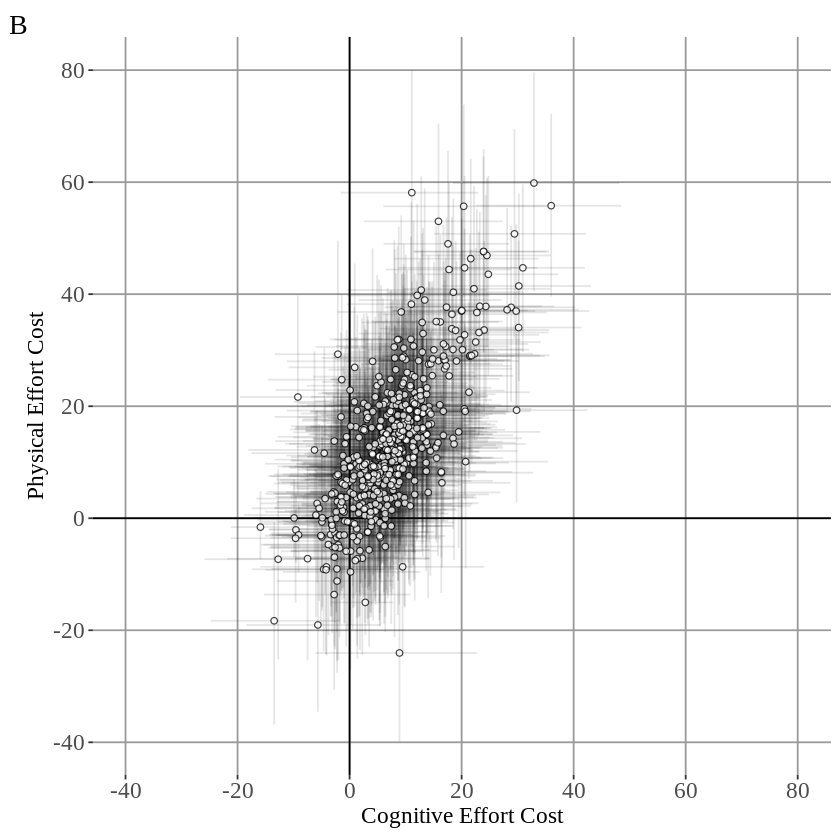

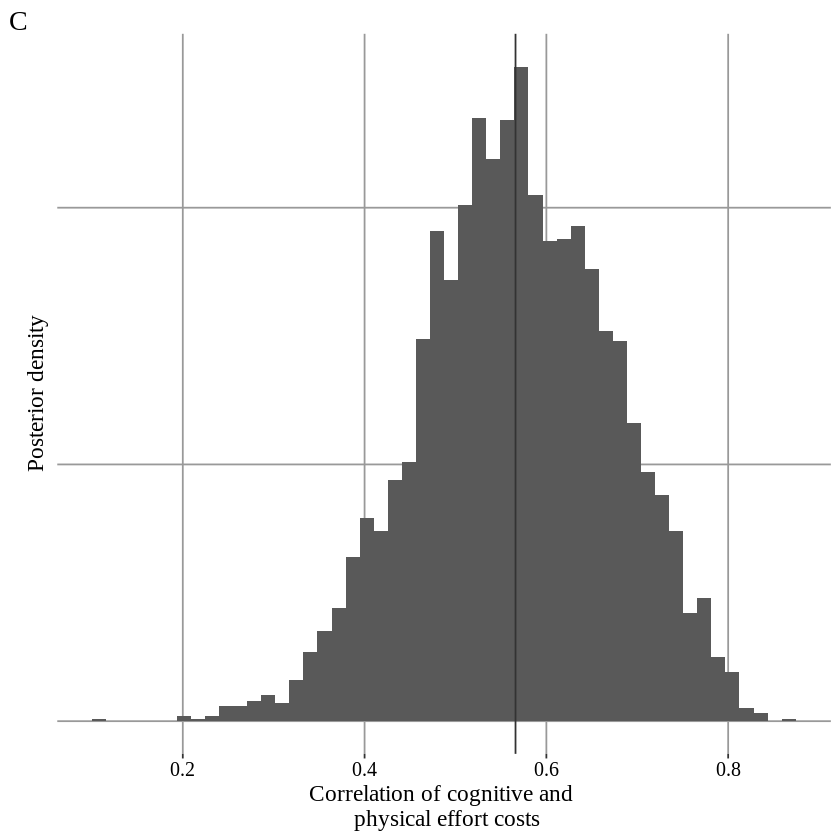

In [22]:
### Figure 4: Correlation between individual differences in cognitive and physical effort costs.
# scatter plot cognitive versus physical effort cost with HDI intervals
cost_travel_param_participant_experiment_1 <- cost_travel_participant_experiment_1 %>%
         mutate(HDIInterval_width = upper - lower) %>%
         ungroup() %>%
         select(-param_name_str) %>%
         pivot_wider(names_from = param_name,
                     values_from = c(mean, lower, upper, HDIInterval_width))
cost_max <- max(max(cost_travel_param_participant_experiment_1$upper_cost_large),
                max(cost_travel_param_participant_experiment_1$upper_cost_mismatching))
cost_min <- min(min(cost_travel_param_participant_experiment_1$lower_cost_large),
                min(cost_travel_param_participant_experiment_1$lower_cost_mismatching))
p_cost_travel_scatter_experiment_1 <- ggplot(data = cost_travel_param_participant_experiment_1,
       aes(x = mean_cost_mismatching,
           y = mean_cost_large)) +
  labs(x = "Cognitive Effort Cost",
       y = "Physical Effort Cost",
       tag = "B") +
  geom_vline(aes(xintercept = 0),
             color = "black") +
  geom_hline(aes(yintercept = 0),
           color = "black") +
  geom_errorbar(aes(xmin = lower_cost_mismatching,
                    xmax = upper_cost_mismatching),
                alpha = 0.1) +
  geom_errorbar(aes(ymin = lower_cost_large,
                    ymax = upper_cost_large),
                alpha = 0.1) +
  geom_point(color = "black",
             fill = "white",
             alpha = 0.75,
             pch=21) +
  theme(text = element_text(size = 14,
                            family = "serif"),
        axis.text = element_text(size = 14),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
    coord_fixed(xlim = c(cost_min, cost_max),
                ylim = c(cost_min, cost_max)) +
  scale_y_continuous(breaks=scales::breaks_pretty()) +
  scale_x_continuous(breaks=scales::breaks_pretty())
print(p_cost_travel_scatter_experiment_1)

p_cog_phys_correlation_posterior_experiment_1 <- ggplot(
  data = cost_travel_stan_fit_experiment_1,
      aes(x = `r[3,5]`)) +
  geom_histogram(bins = 50) +
  geom_vline(aes(xintercept = mean(cost_travel_stan_fit_experiment_1$`r[3,5]`)),
           color = "grey20") +
  labs(y = "Posterior density",
       x = "Correlation of cognitive and \n physical effort costs",
       tag = "C") +
  theme(text = element_text(family = "serif",
                            size = 14),
        axis.text = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.x = element_text(family = "serif",
                            size = 12),
        panel.background = element_blank(),
        panel.grid.major = element_line(size = 0.5,
                                        linetype = 'solid',
                                        colour = "grey60")) +
  scale_x_continuous(breaks=scales::pretty_breaks()) +
  scale_fill_manual(values = c("transparent",
                               "grey50",
                               "transparent"),
                    guide = "none")
print(p_cog_phys_correlation_posterior_experiment_1)


# Question 5:
In this experiment participants who avoided cognitive effort more also avoided physical effort more. What reasons can you think of for why that might be? How does it compare to your real life experiences?

## Run the model yourself!
To run the model you'll need to install cmdstanr. Note the sampling can take hours, so this code will show you how to run the model, which you can try on your own time.

In [ ]:
install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
library(cmdstanr)
install_cmdstan()
check_cmdstan_toolchain()

In [ ]:
urlfile="https://raw.githubusercontent.com/laurabustamante/foraging_tutorial/main/fit_mvt_stan_model_experiment_1.stan"
download.file(urlfile, destfile = "/content/fit_mvt_stan_model_experiment_1.stan")
mod <- cmdstan_model("/content/fit_mvt_stan_model_experiment_1.stan")
# inspect model code
mod$print()

//aria:compile=0
data {
  int NS; // number of particiants
  int K; // length of all trials for all participants 
  array[K] int choose_stay; // whether participant exits the patch (0) or not (1)
  array[K] int<lower=1, upper=NS> which_S;
  vector[K] total_reward; // total rewards per block type
  vector[K] total_harvest_periods; // time spent per block type
  vector[K] number_trees; // how many trees visited per block type
  vector[K] expected_reward; // reward expected on a trial 
  vector[K] is_Matching; // 1 = congruent trial block, 0 = not 
  vector[K] is_Mismatching; // 1 = interference trial block, 0 = not 
  vector[K] is_small; // 1 = physical low efffort block, 0 = not 
  vector[K] is_large; // 1 = physical high efffort block, 0 = not 
} 

transformed data {
  // fixed effects prior ~ N(X_mu_prior, X_s_prior)
  // [1] = log inv_temp
  // [2] = cost_congruent
  // [3] = cost_interference
  // [4] = cost_small
  // [5] = cost_large
  vector[5] gam_mu_prior = [0, 0, 0, 0, 0]';   

In [ ]:
# note the sampling can take hours
fit_experiment_1 <- mod$sample(
  data = foraging_experiment_1_standata,
  chains = 4,
  parallel_chains = 4,
  refresh = 150,
  iter_warmup = 500,
  iter_sampling = 1000,
  thin = 1
)

fit_experiment_1$summary()
cost_travel_experiment_1_fit_full <- fit_experiment_1$draws(format = "df")
# save the draws and also the model fit object
# saveRDS(fit_experiment_1, "fit_experiment_1.rds")
# write_csv(cost_travel_experiment_1_fit_full, "cost_travel_experiment_1_fit_full.csv")

Running MCMC with 4 parallel chains...



Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpj9o3ik/model-946472318a.stan', line 66, column 2 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in '/tmp/Rtmpj9o3ik/model-946472318a.stan', line 66, column 2 to column 44)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but 